Part 1:
This class contains rules to check the quality of a single input image.
It's designed to be fast and work in real-time in the Streamlit app.

In [1]:
import numpy as np
import cv2
from torchvision import datasets

KEY CONCEPTS APPLIED-
1. Class-based Design: Encapsulated all logic into a clean, reusable class.
2. Single-Image Focus: The main `run()` method is designed to analyze one
    image at a time, which is exactly what the Streamlit app needs.
3. Simplified Rules: Replaced some complex rules with more efficient and standard
    OpenCV equivalents (e.g., using Laplacian variance for noise).
4. Parameterized Thresholds: Moved hardcoded numbers into class attributes
    (e.g., self.ROTATION_THRESHOLD), making them easy to see and tune.
5. Clear Output: The `run()` method returns a simple list of warning strings,
    perfect for displaying to the user in the final app.

In [2]:
class ImageQualityValidator:
    """
    A rule-based system to detect potential quality issues in a single
    handwritten digit image before or after prediction.
    """
    def __init__(self):
        # Thresholds can be tuned here
        self.THICKNESS_THRESHOLD_LOW = 0.3  # Ratio of eroded pixels
        self.THICKNESS_THRESHOLD_HIGH = 0.8
        self.POSITION_OFFSET_THRESHOLD = 5  # Pixels from center (for 28x28)
        self.ROTATION_THRESHOLD = 20        # Degrees
        self.NOISE_THRESHOLD = 1500         # Variance of Laplacian
        self.CONTRAST_THRESHOLD_LOW = 0.2   # Std dev of pixel values
        
    def _check_thickness(self, image):
        """Rule to detect very thin or very thick strokes."""
        # Ensure image is binary (0 or 255)
        _, binary_img = cv2.threshold((image * 255).astype(np.uint8), 128, 255, cv2.THRESH_BINARY)
        
        # Erode the image to find the "core" of the strokes
        kernel = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(binary_img, kernel, iterations=1)
        
        # Calculate the ratio of core pixels to total pixels
        total_pixels = cv2.countNonZero(binary_img)
        eroded_pixels = cv2.countNonZero(eroded)
        
        if total_pixels == 0: return None
        
        thickness_ratio = eroded_pixels / total_pixels
        
        if thickness_ratio < self.THICKNESS_THRESHOLD_LOW:
            return f"Image quality warning: Digit strokes appear unusually thin (ratio: {thickness_ratio:.2f})."
        if thickness_ratio > self.THICKNESS_THRESHOLD_HIGH:
            return f"Image quality warning: Digit strokes appear unusually thick or blob-like (ratio: {thickness_ratio:.2f})."
        return None

    def _check_position(self, image):
        """Rule to detect if the digit is significantly off-center."""
        # Find center of mass
        moments = cv2.moments((image > 0.1).astype(np.uint8))
        if moments["m00"] == 0: return None
        
        center_x = int(moments["m10"] / moments["m00"])
        center_y = int(moments["m01"] / moments["m00"])
        
        img_center_x, img_center_y = image.shape[1] // 2, image.shape[0] // 2
        
        offset = np.sqrt((center_x - img_center_x)**2 + (center_y - img_center_y)**2)
        
        if offset > self.POSITION_OFFSET_THRESHOLD:
            return f"Image quality warning: Digit is significantly off-center (offset: {offset:.1f} pixels)."
        return None
        
    def _check_rotation(self, image):
        """Rule to detect if the digit is heavily rotated."""
        # Find contours of the digit
        contours, _ = cv2.findContours((image > 0.1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours: return None
        
        # Use the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get the angle from the minimum area rectangle
        # The angle returned is between -90 and 0
        _, _, angle = cv2.minAreaRect(largest_contour)
        
        # Normalize angle to be between 0 and 90
        if angle < -45:
            angle = 90 + angle
            
        if abs(angle) > self.ROTATION_THRESHOLD:
            return f"Image quality warning: Digit may be rotated by ~{abs(angle):.0f} degrees."
        return None

    def _check_noise_and_blur(self, image):
        """Rule to estimate noise or blur using Laplacian variance."""
        # The variance of the Laplacian is a good measure of focus/clarity
        laplacian_var = cv2.Laplacian((image * 255).astype(np.uint8), cv2.CV_64F).var()
        if laplacian_var < 100: # Very low variance can indicate blur
             return f"Image quality warning: Image appears blurry (Laplacian var: {laplacian_var:.0f})."
        if laplacian_var > self.NOISE_THRESHOLD:
            return f"Image quality warning: Image appears noisy (Laplacian var: {laplacian_var:.0f})."
        return None
        
    def run(self, image_np):
        """
        Runs all quality checks on a single numpy image.
        The image should be a 2D numpy array (e.g., 28x28).
        """
        warnings = []
        
        # Ensure image is normalized between 0 and 1 for consistency
        if image_np.max() > 1.0:
            image_np = image_np / 255.0
            
        checks = [
            self._check_thickness,
            self._check_position,
            self._check_rotation,
            self._check_noise_and_blur,
        ]
        
        for check_func in checks:
            result = check_func(image_np)
            if result:
                warnings.append(result)
                
        return warnings

Part 2: Example Usage Block
==============================================================================
This block demonstrates how to use the validator.

--- Analyzing Sample Image for Digit '5' ---
⚠️ The following quality issues were detected:
  - Image quality warning: Digit strokes appear unusually thin (ratio: 0.00).
  - Image quality warning: Digit may be rotated by ~90 degrees.
  - Image quality warning: Image appears noisy (Laplacian var: 15145).


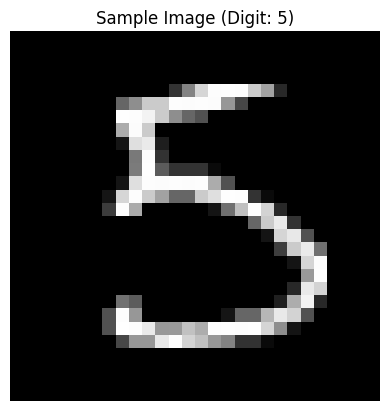

In [3]:
# 1. Load the MNIST test dataset to get a sample image
test_dataset = datasets.MNIST(root='./data', train=False, download=True)
sample_image_pil, sample_label = test_dataset[15]  # Let's pick an interesting image
sample_image_np = np.array(sample_image_pil)

# 2. Instantiate the validator
validator = ImageQualityValidator()

# 3. Run the analysis on our sample image
print(f"--- Analyzing Sample Image for Digit '{sample_label}' ---")
warnings_found = validator.run(sample_image_np)

# 4. Print the results
if not warnings_found:
    print("✅ No quality issues detected.")
else:
    print("⚠️ The following quality issues were detected:")
    for warning in warnings_found:
        print(f"  - {warning}")

# 5. Visualize the image we just tested
import matplotlib.pyplot as plt
plt.imshow(sample_image_np, cmap='gray')
plt.title(f"Sample Image (Digit: {sample_label})")
plt.axis('off')
plt.show()